Adam Sohn W205 10/19

Note: For better-formatted SQL code, see README_Sohn.md file

### Project1: Query Project

- In the Query Project, you will get practice with SQL while learning about
  Google Cloud Platform (GCP) and BiqQuery. You'll answer business-driven
  questions using public datasets housed in GCP. To give you experience with
  different ways to use those datasets, you will use the web UI (BiqQuery) and
  the command-line tools, and work with them in jupyter notebooks.

- We will be using the Bay Area Bike Share Trips Data
  (https://cloud.google.com/bigquery/public-data/bay-bike-share). 

### Problem Statement

- You're a data scientist at Ford GoBike (https://www.fordgobike.com/), the
  company running Bay Area Bikeshare. You are trying to increase ridership, and
  you want to offer deals through the mobile app to do so. What deals do you
  offer though? Currently, your company has three options: a flat price for a
  single one-way trip, a day pass that allows unlimited 30-minute rides for 24
  hours and an annual membership. 

- Through this project, you will answer these questions: 
  * What are the 5 most popular trips that you would call "commuter trips"?
  * What are your recommendations for offers (justify based on your findings)?

_______________________________

### Loading Packages

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Breaking down assignment into assumptions and research questions
1) What are the 5 most popular trips that you would call "commuter trips"?<br>
#### Assuming:
* 'most popular' = highest trip count over entire time period.
* 'commuter' = A rider who rides a consistent start/end station trip at consistent times on consistent days. Traditionally, there will be a large contingent of riders taking their commuting trips during a morning 'rush' time range and an afternoon 'rush' time range. 
* 'commuter trip' = Any trip occuring at a time when commuters are likely riding.<br>

#### Research Questions:
* Research Question A: Is there a morning/afternoon 'rush' time range suggested by ridership data?
* Research Question A_1: Does weekday (M-F) vs. weekend (Sa-Su) ridership help identify the commuting population?
* Research Question A_2: Does customer type of 'Subscriber' or 'Customer' (ie. not a 'Subscriber') help identify the commuting population? 
* Research Question B: Leveraging all learning from Research Question A, establish 5 most popular trips that could be called commuter trips.
--------------------------------
2) What are your recommendations for offers (justify based on your findings)?<br>
#### Assuming:
* 'offers' are deterimental to revenue when offerred to committed customers who are willing to pay full price
* 'offers' that increase demand may disenfrachise Subscribers for the sake of bike availability when offered at high demand times and/or at high demand start_stations.
* 'committed customers' are considered to be Subscribers

#### Research Questions:
* Research Question C: Characterize what days would be the bikes would have lowest utilization by Subscribers.
* Research Question D: Characterize seasonality of trip count (as a proxy for bike utilization).
* Research Question E: Which are the high-volume (>10k trips) stations with the lowest percentages of their weekday outgoing trips coinciding with rush times?
* Research Question F: Leveraging all learning from Research Question C, D, E to determine a promotional strategy.

_______________________________

### Research Question A: Is there a morning/afternoon 'rush' time range suggested by ridership data?

Motivation for Research Question A:<br>Assuming participation in 'rush' times is a defining factor of commuters, this query will help the researcher define 'rush' times for Ford GoBike customers. 

In [40]:
! bq query --use_legacy_sql=false 'SELECT EXTRACT(hour FROM start_date) AS hour_of_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`),1) AS percentage_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY hour_of_day ORDER BY percentage_of_trips DESC' 

Waiting on bqjob_r7d65c34c27a2823f_0000016d90115345_1 ... (0s) Current status: DONE   
+-------------+---------------------+
| hour_of_day | percentage_of_trips |
+-------------+---------------------+
|           8 |                13.5 |
|          17 |                12.8 |
|           9 |                 9.8 |
|          16 |                 9.0 |
|          18 |                 8.6 |
|           7 |                 6.9 |
|          12 |                 4.8 |
|          15 |                 4.8 |
|          13 |                 4.4 |
|          10 |                 4.3 |
|          19 |                 4.2 |
|          11 |                 4.1 |
|          14 |                 3.8 |
|          20 |                 2.3 |
|           6 |                 2.1 |
|          21 |                 1.6 |
|          22 |                 1.0 |
|          23 |                 0.6 |
|           5 |                 0.5 |
|           0 |                 0.3 |
|           1 |                 0.2 |
|

In [41]:
# Store table to A.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(hour FROM start_date) AS hour_of_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`),1) AS percentage_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY hour_of_day ORDER BY percentage_of_trips DESC' > A.csv

Waiting on bqjob_r6ef50a2249cd5922_0000016d90115a4f_1 ... (0s) Current status: DONE   

In [42]:
# Import A.csv as dataframe A_df 
A_df = pd.read_csv('A.csv')

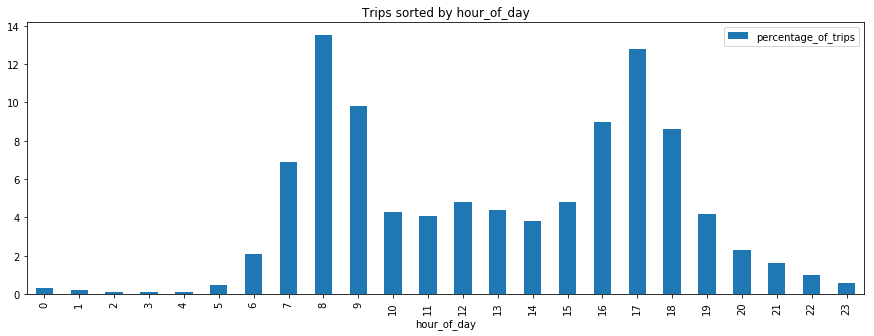

In [43]:
# Plotting bar chart of percentage of trips per hourly time bucket
A_df = A_df.sort_values(by=['hour_of_day'])
A_df.plot(x ='hour_of_day', y='percentage_of_trips', kind = 'bar', figsize = (15,5), title = 'Trips sorted by hour_of_day')

<font color='blue'> Conclusion for Research Question A:<br>The most popular trip start times are in the 7-9 hrs & 16-18 hrs. This coincides with common understanding of 'rush' times. </font>

_______________________________

### Research Question A_1: Does weekday (M-F) vs. weekend (Sa-Su) ridership help identify the commuting population?

Motivation for Research Question A_1:<br>
Validate assumption that 'rush' times is a weekday only phenomena.

In [44]:
print('FOR WEEKEND')
! bq query --use_legacy_sql=false 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekend_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (1,7)),1) AS percentage_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (1,7) GROUP BY hour_of_weekend_day ORDER BY percentage_of_trips DESC'

FOR WEEKEND
Waiting on bqjob_r7196035a0a8fb4a1_0000016d901161cc_1 ... (0s) Current status: DONE   
+---------------------+---------------------+
| hour_of_weekend_day | percentage_of_trips |
+---------------------+---------------------+
|                  13 |                 9.6 |
|                  12 |                 9.5 |
|                  14 |                 9.2 |
|                  15 |                 9.1 |
|                  11 |                 8.7 |
|                  16 |                 8.7 |
|                  10 |                 7.1 |
|                  17 |                 7.1 |
|                  18 |                 5.7 |
|                   9 |                 5.2 |
|                  19 |                 4.0 |
|                   8 |                 3.1 |
|                  20 |                 2.9 |
|                  21 |                 2.2 |
|                  22 |                 1.7 |
|                   7 |                 1.5 |
|                  23 |    

In [45]:
print('\nFOR WEEKDAY')
! bq query --use_legacy_sql=false 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekday_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6)),1) AS percentage_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY hour_of_weekday_day ORDER BY percentage_of_trips DESC' 


FOR WEEKDAY
Waiting on bqjob_r12e2dc1de1199704_0000016d9011675e_1 ... (0s) Current status: DONE   
+---------------------+---------------------+
| hour_of_weekday_day | percentage_of_trips |
+---------------------+---------------------+
|                   8 |                14.8 |
|                  17 |                13.6 |
|                   9 |                10.4 |
|                  16 |                 9.1 |
|                  18 |                 9.0 |
|                   7 |                 7.6 |
|                  15 |                 4.3 |
|                  12 |                 4.2 |
|                  19 |                 4.2 |
|                  10 |                 4.0 |
|                  13 |                 3.8 |
|                  11 |                 3.5 |
|                  14 |                 3.2 |
|                   6 |                 2.3 |
|                  20 |                 2.2 |
|                  21 |                 1.5 |
|                  22 |   

In [46]:
# Store table to A_1_weekend.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekend_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (1,7)),1) AS percentage_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (1,7) GROUP BY hour_of_weekend_day ORDER BY percentage_of_trips DESC' > A_1_weekend.csv

# Store table to A_1_weekday.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekday_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6)),1) AS percentage_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY hour_of_weekday_day ORDER BY percentage_of_trips DESC' > A_1_weekday.csv 

Waiting on bqjob_r6233d76a6b040178_0000016d901172ad_1 ... (0s) Current status: DONE   

In [47]:
# Import A_1_weekend.csv as dataframe A_1_weekend_df
A_1_weekend_df = pd.read_csv('A_1_weekend.csv')
# Import A_1_weekday.csv as dataframe A_1_weekday_df
A_1_weekday_df = pd.read_csv('A_1_weekday.csv')

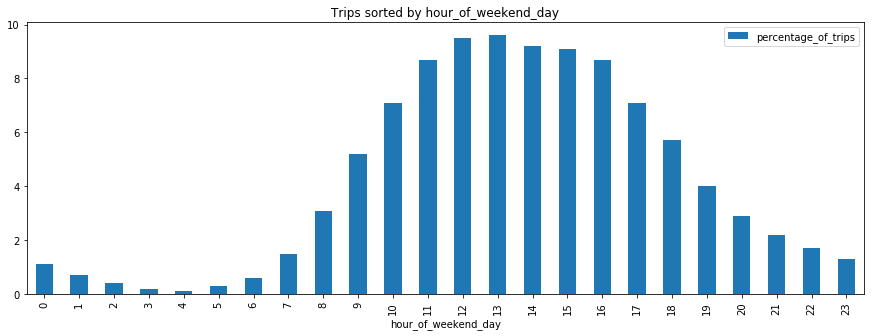

In [48]:
# Plotting bar chart of percentage of trips per hourly time bucket for weekend days only
A_1_weekend_df = A_1_weekend_df.sort_values(by=['hour_of_weekend_day'])
A_1_weekend_df.plot(x ='hour_of_weekend_day', y='percentage_of_trips', kind = 'bar', figsize = (15,5), title = 'Trips sorted by hour_of_weekend_day')

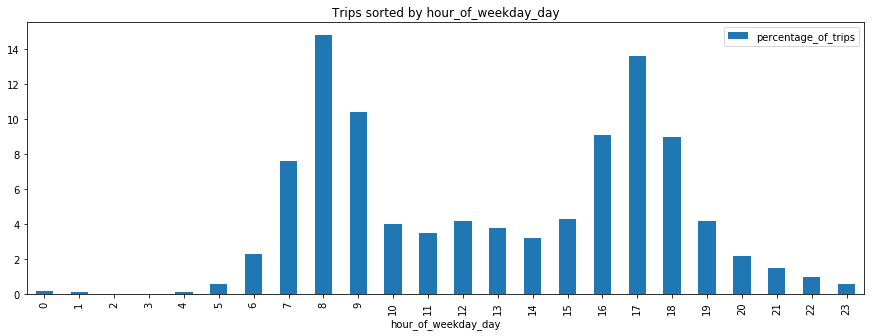

In [49]:
# Plotting bar chart of percentage of trips per hourly time bucket for weekday days only
A_1_weekday_df = A_1_weekday_df.sort_values(by=['hour_of_weekday_day'])
A_1_weekday_df.plot(x ='hour_of_weekday_day', y='percentage_of_trips', kind = 'bar', figsize = (15,5), title = 'Trips sorted by hour_of_weekday_day')

<font color='blue'>Conclusion for Research Question A_1:<br>For weekends, the most popular trip start times move from traditional 'rush' start times in the 7-9 hrs & 16-18 hrs to mid-day 11-16 hrs. Additionaly, the trips are less concentrated in any given hr. This reflects a high-level change in usage pattern between week and weekend which will be interpretted as weekend trips being primarily recreational, not commuting. </font>

_______________________________

### Research Question A_2: Does customer type of 'Subscriber' or 'Customer' (ie. not a 'Subscriber') help identify the commuting population?

Motivation for Research Question A_2:<br>
Assuming commuters would likely be subscribers and other rider types would be less likely to be subscribers (than commuters), true 'rush' should exhibit a higher percentage of subscribers than other times. 

Note:<br>Since A_1 has already proved weekdays (and not weekends) show the 'rush' times, A_2 will assume weekdays only for analysis.

In [50]:
print('FOR CUSTOMER (non-subscriber)')
! bq query --use_legacy_sql=false 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekday_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type != "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6)),1) AS percentage_of_trips_customer FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type != "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY hour_of_weekday_day ORDER BY percentage_of_trips_customer DESC'

FOR CUSTOMER (non-subscriber)
Waiting on bqjob_r30fd078bbf90b86_0000016d90117c13_1 ... (0s) Current status: DONE   
+---------------------+------------------------------+
| hour_of_weekday_day | percentage_of_trips_customer |
+---------------------+------------------------------+
|                  17 |                          9.0 |
|                  16 |                          9.0 |
|                  15 |                          8.6 |
|                  12 |                          8.3 |
|                  14 |                          8.3 |
|                  13 |                          8.2 |
|                  11 |                          7.6 |
|                  18 |                          7.1 |
|                  10 |                          5.7 |
|                   9 |                          5.1 |
|                   8 |                          5.0 |
|                  19 |                          4.4 |
|                  20 |                          3.0 |
|   

In [51]:
print('FOR SUBSCRIBER')
! bq query --use_legacy_sql=false 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekday_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6)),1) AS percentage_of_trips_subscriber FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY hour_of_weekday_day ORDER BY percentage_of_trips_subscriber DESC'

FOR SUBSCRIBER
Waiting on bqjob_r5421d4029ca112dd_0000016d90118197_1 ... (0s) Current status: DONE   
+---------------------+--------------------------------+
| hour_of_weekday_day | percentage_of_trips_subscriber |
+---------------------+--------------------------------+
|                   8 |                           15.8 |
|                  17 |                           14.0 |
|                   9 |                           10.9 |
|                  18 |                            9.2 |
|                  16 |                            9.1 |
|                   7 |                            8.1 |
|                  19 |                            4.2 |
|                  15 |                            3.8 |
|                  10 |                            3.8 |
|                  12 |                            3.7 |
|                  13 |                            3.3 |
|                  11 |                            3.1 |
|                  14 |                    

In [52]:
# Store table to A_2_customer.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekday_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type != "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6)),1) AS percentage_of_trips_customer FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type != "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY hour_of_weekday_day ORDER BY percentage_of_trips_customer DESC' > A_2_customer.csv

# Store table to A_2_subscriber.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(hour FROM start_date) AS hour_of_weekday_day, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6)),1) AS percentage_of_trips_subscriber FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY hour_of_weekday_day ORDER BY percentage_of_trips_subscriber DESC'  > A_2_subscriber.csv

Waiting on bqjob_r506df46fe886e8cc_0000016d90118cbb_1 ... (0s) Current status: DONE   

In [53]:
# Import A_2_customer.csv as dataframe A_2_customer_df
A_2_customer_df = pd.read_csv('A_2_customer.csv')
# Import A_2_subscriber.csv as dataframe A_2_subscriber_df
A_2_subscriber_df = pd.read_csv('A_2_subscriber.csv')

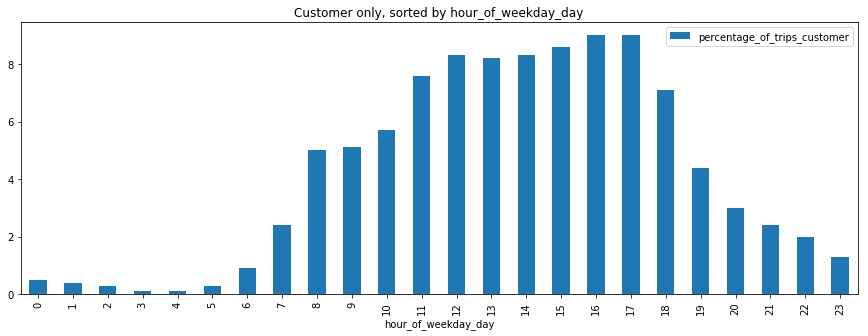

In [54]:
# Plotting bar chart of percentage of trips per hourly time bucket for weekday days only
A_2_customer_df = A_2_customer_df.sort_values(by=['hour_of_weekday_day'])
A_2_customer_df.plot(x ='hour_of_weekday_day', y='percentage_of_trips_customer', kind = 'bar', figsize = (15,5), title = 'Customer only, sorted by hour_of_weekday_day')

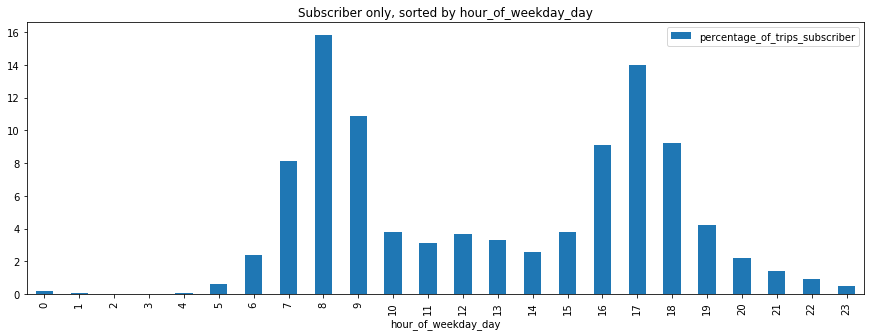

In [55]:
# Plotting bar chart of percentage of trips per hourly time bucket for weekday days only
A_2_subscriber_df = A_2_subscriber_df.sort_values(by=['hour_of_weekday_day'])
A_2_subscriber_df.plot(x ='hour_of_weekday_day', y='percentage_of_trips_subscriber', kind = 'bar', figsize = (15,5), title = 'Subscriber only, sorted by hour_of_weekday_day')

<font color='blue'> Conclusion for Research Question A_2: <br>Yes! When viewing weekdays by hourly buckets of start_date, Customer (not Subscriber) trips only show 1 hour coincident (17) with the Subscriber trips. The subscriber trips more closely coincide with expectation. This finding was expected based on the expectation that habitual customers (ie. commuters) would require the convenience of a subscription. </font>

_______________________________

### Research Question B: Leveraging all learning from Research Question A, establish 5 most popular trips that could be called commuter trips.

Motivation for Question B:<br>Culmination of examination of commuter habits

In [56]:
print('Filtered on Subscriber, Weekday, start_time in (7,8,9,16,17,18)')
! bq query --use_legacy_sql=false 'SELECT start_station_name, end_station_name, ROUND(100 * count(*)/(SELECT COUNT(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) AND EXTRACT(HOUR FROM start_date) in (7,8,9,16,17,18)),2) AS pct_of_rush_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) AND EXTRACT(HOUR FROM start_date) in (7,8,9,16,17,18) GROUP BY start_station_name, end_station_name ORDER BY pct_of_rush_trips DESC LIMIT 5'

Filtered on Subscriber, Weekday, start_time in (7,8,9,16,17,18)
Waiting on bqjob_r7704063e683613b6_0000016d901195d2_1 ... (0s) Current status: DONE   
+-----------------------------------------+------------------------------------------+-------------------+
|           start_station_name            |             end_station_name             | pct_of_rush_trips |
+-----------------------------------------+------------------------------------------+-------------------+
| 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building)     |              0.95 |
| Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                          |              0.94 |
| San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                          |              0.94 |
| Embarcadero at Sansome                  | Steuart at Market                        |              0.88 |
| Embarcadero at Folsom                   | San Francisco Caltrain (Townsend at 4th) |              

<font color='blue'> Conclusion for Research Question B: <br>Using all learnings on isolating commuter trips (Subscibers only, start_date in one of the following hours: 7,8,9,16,17,18, weekdays only), the above combinations comprise the top 5 popular trips that could be called commuter trips.</font>

_______________________________

### Research Question C: Characterize what days would be the bikes would have lowest utilization by Subscribers.

Motivation for Question C:<br>These days are the best options for fare sale days, as subscribers are least likely to be disenfranchised by lack of bike availability.

In [57]:
print('Characterizing 50 lowest-ridership days')
! bq query --use_legacy_sql=false 'SELECT DATE_TRUNC(DATE(start_date), DAY) as date, COUNT(DATE_TRUNC(DATE(start_date), DAY)) as trips, CASE   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "Sunday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "Monday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "Tuesday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN  "Wednesday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "Thursday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "Friday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "Saturday"   ELSE "error" END AS day_of_week, CASE  	WHEN EXTRACT(MONTH FROM start_date) BETWEEN 1 and 2 then "Winter"   WHEN EXTRACT(MONTH FROM start_date) BETWEEN 3 and 5 then "Spring" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 6 and 8 then "Summer" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 9 and 11 then "Fall"   WHEN EXTRACT(MONTH FROM start_date) = 12 then "Winter"   ELSE "error" END AS season,  CASE   WHEN DATE_TRUNC(DATE(start_date), DAY) in ("2013-01-01","2013-01-21","2013-02-18","2013-05-27","2013-07-04","2013-09-02","2013-10-14","2013-11-11","2013-11-28","2013-12-25","2014-01-01","2014-01-20","2014-02-17","2014-05-26","2014-07-04","2014-09-01","2014-10-13","2014-11-11","2014-11-27","2014-12-25","2015-01-01","2015-01-19","2015-02-16","2015-05-25","2015-07-03","2015-09-07","2015-10-12","2015-11-11","2015-11-26","2015-12-25","2016-01-01","2016-01-18","2016-02-15","2016-05-30","2016-07-04","2016-09-05","2016-10-10","2016-11-11","2016-11-24","2016-12-26","2013-01-02","2013-01-22","2013-02-19","2013-05-28","2013-07-05","2013-09-03","2013-10-15","2013-11-12","2013-11-29","2013-12-26","2014-01-02","2014-01-21","2014-02-18","2014-05-27","2014-07-05","2014-09-02","2014-10-14","2014-11-12","2014-11-28","2014-12-26","2015-01-02","2015-01-20","2015-02-17","2015-05-26","2015-07-04","2015-09-08","2015-10-13","2015-11-12","2015-11-27","2015-12-26","2016-01-02","2016-01-19","2016-02-16","2016-05-31","2016-07-05","2016-09-06","2016-10-11","2016-11-12","2016-11-25","2016-12-27","2012-12-31","2013-01-20","2013-02-17","2013-05-26","2013-07-03","2013-09-01","2013-10-13","2013-11-10","2013-11-27","2013-12-24","2013-12-31","2014-01-19","2014-02-16","2014-05-25","2014-07-03","2014-08-31","2014-10-12","2014-11-10","2014-11-26","2014-12-24","2014-12-31","2015-01-18","2015-02-15","2015-05-24","2015-07-02","2015-09-06","2015-10-11","2015-11-10","2015-11-25","2015-12-24","2015-12-31","2016-01-17","2016-02-14","2016-05-29","2016-07-03","2016-09-04","2016-10-09","2016-11-10","2016-11-23","2016-12-25" ) then "Yes" ELSE "No" END AS federal_holiday_plus_minus_1_day FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" GROUP BY date, day_of_week, season, federal_holiday_plus_minus_1_day ORDER BY trips ASC LIMIT 50'
# Credit for date list of Federal Holidays: https://stackoverflow.com/questions/3327007/database-of-actual-federal-holidays-closure

Characterizing 50 lowest-ridership days
Waiting on bqjob_r3d3f7621736b9126_0000016d90119c13_1 ... (0s) Current status: DONE   
+------------+-------+-------------+--------+----------------------------------+
|    date    | trips | day_of_week | season | federal_holiday_plus_minus_1_day |
+------------+-------+-------------+--------+----------------------------------+
| 2015-12-20 |    37 | Sunday      | Winter | No                               |
| 2016-01-01 |    44 | Friday      | Winter | Yes                              |
| 2015-12-25 |    45 | Friday      | Winter | Yes                              |
| 2014-12-25 |    45 | Thursday    | Winter | Yes                              |
| 2016-03-13 |    46 | Sunday      | Spring | No                               |
| 2016-03-05 |    54 | Saturday    | Spring | No                               |
| 2015-12-13 |    57 | Sunday      | Winter | No                               |
| 2015-12-27 |    58 | Sunday      | Winter | No               

In [58]:
#Store table to C.csv. 
! bq query --use_legacy_sql=false --format=csv 'SELECT DATE_TRUNC(DATE(start_date), DAY) as date, COUNT(DATE_TRUNC(DATE(start_date), DAY)) as trips, CASE   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "Sunday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "Monday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "Tuesday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN  "Wednesday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "Thursday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "Friday"   WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "Saturday"   ELSE "error" END AS day_of_week, CASE  	WHEN EXTRACT(MONTH FROM start_date) BETWEEN 1 and 2 then "Winter"   WHEN EXTRACT(MONTH FROM start_date) BETWEEN 3 and 5 then "Spring" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 6 and 8 then "Summer" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 9 and 11 then "Fall"   WHEN EXTRACT(MONTH FROM start_date) = 12 then "Winter"   ELSE "error" END AS season,  CASE   WHEN DATE_TRUNC(DATE(start_date), DAY) in ("2013-01-01","2013-01-21","2013-02-18","2013-05-27","2013-07-04","2013-09-02","2013-10-14","2013-11-11","2013-11-28","2013-12-25","2014-01-01","2014-01-20","2014-02-17","2014-05-26","2014-07-04","2014-09-01","2014-10-13","2014-11-11","2014-11-27","2014-12-25","2015-01-01","2015-01-19","2015-02-16","2015-05-25","2015-07-03","2015-09-07","2015-10-12","2015-11-11","2015-11-26","2015-12-25","2016-01-01","2016-01-18","2016-02-15","2016-05-30","2016-07-04","2016-09-05","2016-10-10","2016-11-11","2016-11-24","2016-12-26","2013-01-02","2013-01-22","2013-02-19","2013-05-28","2013-07-05","2013-09-03","2013-10-15","2013-11-12","2013-11-29","2013-12-26","2014-01-02","2014-01-21","2014-02-18","2014-05-27","2014-07-05","2014-09-02","2014-10-14","2014-11-12","2014-11-28","2014-12-26","2015-01-02","2015-01-20","2015-02-17","2015-05-26","2015-07-04","2015-09-08","2015-10-13","2015-11-12","2015-11-27","2015-12-26","2016-01-02","2016-01-19","2016-02-16","2016-05-31","2016-07-05","2016-09-06","2016-10-11","2016-11-12","2016-11-25","2016-12-27","2012-12-31","2013-01-20","2013-02-17","2013-05-26","2013-07-03","2013-09-01","2013-10-13","2013-11-10","2013-11-27","2013-12-24","2013-12-31","2014-01-19","2014-02-16","2014-05-25","2014-07-03","2014-08-31","2014-10-12","2014-11-10","2014-11-26","2014-12-24","2014-12-31","2015-01-18","2015-02-15","2015-05-24","2015-07-02","2015-09-06","2015-10-11","2015-11-10","2015-11-25","2015-12-24","2015-12-31","2016-01-17","2016-02-14","2016-05-29","2016-07-03","2016-09-04","2016-10-09","2016-11-10","2016-11-23","2016-12-25" ) then "Yes" ELSE "No" END AS federal_holiday_plus_minus_1_day FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" GROUP BY date, day_of_week, season, federal_holiday_plus_minus_1_day ORDER BY trips ASC LIMIT 50' > C.csv

Waiting on bqjob_reb454e3e3ba1ad_0000016d9011a220_1 ... (0s) Current status: DONE   

In [59]:
# Import C.csv as dataframe C_df
C_df = pd.read_csv('C.csv')

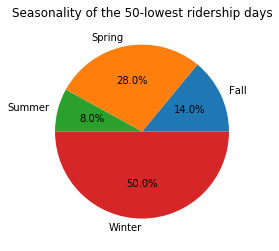

In [60]:
# Plotting pie chart of 50-lowest ridership days by season
X = C_df.groupby(['season'])['season'].count() #Grouping days by season
X.plot.pie(title = 'Seasonality of the 50-lowest ridership days', label='', autopct='%1.1f%%')

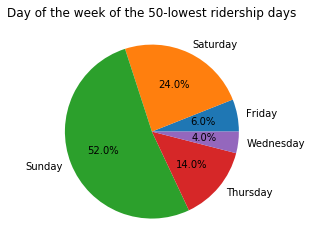

In [61]:
# Plotting pie chart of 50-lowest ridership days by day of the week
X = C_df.groupby(['day_of_week'])['day_of_week'].count() #Grouping days by day of the week
X.plot.pie(title = 'Day of the week of the 50-lowest ridership days', label='', autopct='%1.1f%%')

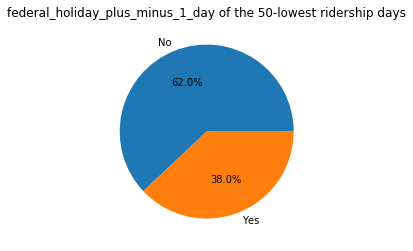

In [62]:
# Plotting pie chart of 50-lowest ridership days by federal_holiday_plus_minus_1_day 
X = C_df.groupby(['federal_holiday_plus_minus_1_day'])['federal_holiday_plus_minus_1_day'].count() #Grouping days by federal_holiday_plus_minus_1_day 
X.plot.pie(title ='federal_holiday_plus_minus_1_day of the 50-lowest ridership days', label='', autopct='%1.1f%%')

<font color='blue'> Conclusion for Research Question C: <br> The low ridership trend demonstrates the following attributes of a day to be detrimental to ridership: weekend, winter season, and being within 1 day (inclusive) of federal holidays.</font>

_______________________________

### Research Question D: Characterize seasonality of trip count (with trip count as a proxy for bike utilization).

Motivation for Research Question D:<br>Running subscription promotions after the peak of ridership has subsided will help keep bike utilization high during the 'off season'.

In [63]:
print('Limiting output to 5 rows only')
! bq query --use_legacy_sql=false 'SELECT DATE_TRUNC(DATE(start_date), MONTH) as date_month, COUNT(DATE_TRUNC(DATE(start_date), DAY)) as trips, CASE WHEN EXTRACT(MONTH FROM start_date) BETWEEN 1 and 2 then "Winter" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 3 and 5 then "Spring" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 6 and 8 then "Summer" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 9 and 11 then "Fall" WHEN EXTRACT(MONTH FROM start_date) = 12 then "Winter" ELSE "error" END AS season FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY season, date_month ORDER BY date_month ASC LIMIT 5'

Limiting output to 5 rows only
Waiting on bqjob_r294bb7225cb6a82e_0000016d9011a9eb_1 ... (0s) Current status: DONE   
+------------+-------+--------+
| date_month | trips | season |
+------------+-------+--------+
| 2013-08-01 |  2102 | Summer |
| 2013-09-01 | 25243 | Fall   |
| 2013-10-01 | 29105 | Fall   |
| 2013-11-01 | 24219 | Fall   |
| 2013-12-01 | 19894 | Winter |
+------------+-------+--------+


In [64]:
#Store table to D.csv. Note this is not restricted to 5 rows
! bq query --use_legacy_sql=false --format=csv 'SELECT DATE_TRUNC(DATE(start_date), MONTH) as date_month, COUNT(DATE_TRUNC(DATE(start_date), DAY)) as trips, CASE WHEN EXTRACT(MONTH FROM start_date) BETWEEN 1 and 2 then "Winter" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 3 and 5 then "Spring" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 6 and 8 then "Summer" WHEN EXTRACT(MONTH FROM start_date) BETWEEN 9 and 11 then "Fall" WHEN EXTRACT(MONTH FROM start_date) = 12 then "Winter" ELSE "error" END AS season FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY season, date_month ORDER BY date_month ASC' > D.csv

Waiting on bqjob_r2478796c3ea20990_0000016d9011af47_1 ... (0s) Current status: DONE   

In [65]:
# Import D.csv as dataframe D_df
D_df = pd.read_csv('D.csv')

In [66]:
#Creating 'season_yr' column to combine Season and Month information
D_df['season_yr'] = D_df['season'] + " " + D_df['date_month'].str[:-3]
D_df.head()

,date_month,trips,season,season_yr
0,2013-08-01,2102,Summer,Summer 2013-08
1,2013-09-01,25243,Fall,Fall 2013-09
2,2013-10-01,29105,Fall,Fall 2013-10
3,2013-11-01,24219,Fall,Fall 2013-11
4,2013-12-01,19894,Winter,Winter 2013-12


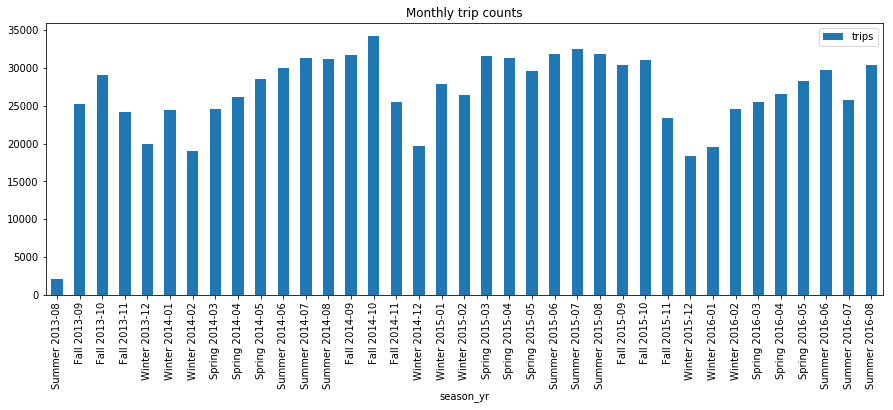

In [67]:
#Plotting bar chart of monthly trip counts to highlight seasonal trends
D_df.plot(x ='season_yr', y='trips', kind = 'bar', figsize = (15,5), title = 'Monthly trip counts')


<font color='blue'> Conclusion for Research Question D: <br>As suspected, there are more trips in summer months than winter months, with fall and spring being transitional times. Winter (and December especially) are consistently low-ridership months. This information can be leveraged for timings of sales, as increased demand (on the aggregate) would not disenfranchise Subscribers from having an available bike.  </font>

_______________________________

### Research Question E: Which are the high-volume (>10k trips) stations with the lowest percentages of their outgoing weekday trips coinciding with rush times?

Motivation for Question E:<br>These stations are underperforming from a subscriber perspective and could benefit from a station-specific promotion.

In [68]:
print('Limiting output to 10 lowest (percentage_of_trips_during_rush) rows only')
! bq query --use_legacy_sql=false 'SELECT bk.start_station_name, ROUND(100 * count(bk.start_station_name)/(SUM(sub.stn_cnt)/COUNT(sub.stn_cnt)),1) AS percentage_of_trips_during_rush, count(bk.start_station_name) as rsh_trip, CAST(sum(sub.stn_cnt)/COUNT(sub.stn_cnt) as int64) as wkday_trip FROM `bigquery-public-data.san_francisco.bikeshare_trips`as bk JOIN (SELECT start_station_name, COUNT(start_station_name) as stn_cnt FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY start_station_name HAVING COUNT(start_station_name) > 10000) sub ON bk.start_station_name = sub.start_station_name WHERE EXTRACT(DAYOFWEEK FROM bk.start_date) in (2,3,4,5,6) AND EXTRACT(hour FROM bk.start_date) in (7,8,9,16,17,18) GROUP BY bk.start_station_name HAVING COUNT(bk.start_station_name) > 10000 ORDER BY percentage_of_trips_during_rush ASC LIMIT 10'

Limiting output to 10 lowest (percentage_of_trips_during_rush) rows only
Waiting on bqjob_r1698fd03d5849277_0000016d9011b7f4_1 ... (0s) Current status: DONE   
+-----------------------------------+---------------------------------+----------+------------+
|        start_station_name         | percentage_of_trips_during_rush | rsh_trip | wkday_trip |
+-----------------------------------+---------------------------------+----------+------------+
| Market at 4th                     |                            50.6 |    11612 |      22966 |
| Powell Street BART                |                            51.1 |    10846 |      21242 |
| Embarcadero at Sansome            |                            57.5 |    18587 |      32345 |
| Market at Sansome                 |                            58.5 |    18880 |      32248 |
| Embarcadero at Bryant             |                            59.3 |    10689 |      18031 |
| 2nd at Folsom                     |                            61.8 | 

In [69]:
#Store table to E.csv. Note this is not restricted to 10 rows
! bq query --use_legacy_sql=false --format=csv 'SELECT bk.start_station_name, ROUND(100 * count(bk.start_station_name)/(SUM(sub.stn_cnt)/COUNT(sub.stn_cnt)),1) AS percentage_of_trips_during_rush, count(bk.start_station_name) as rsh_trip, CAST(sum(sub.stn_cnt)/COUNT(sub.stn_cnt) as int64) as wkday_trip FROM `bigquery-public-data.san_francisco.bikeshare_trips`as bk JOIN (SELECT start_station_name, COUNT(start_station_name) as stn_cnt FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) in (2,3,4,5,6) GROUP BY start_station_name HAVING COUNT(start_station_name) > 10000) sub ON bk.start_station_name = sub.start_station_name WHERE EXTRACT(DAYOFWEEK FROM bk.start_date) in (2,3,4,5,6) AND EXTRACT(hour FROM bk.start_date) in (7,8,9,16,17,18) GROUP BY bk.start_station_name HAVING COUNT(bk.start_station_name) > 10000 ORDER BY percentage_of_trips_during_rush ASC' > E.csv

Waiting on bqjob_r3ece598bcd780927_0000016d9011bd70_1 ... (0s) Current status: DONE   

In [70]:
# Import E.csv as dataframe E_df
E_df = pd.read_csv('E.csv')

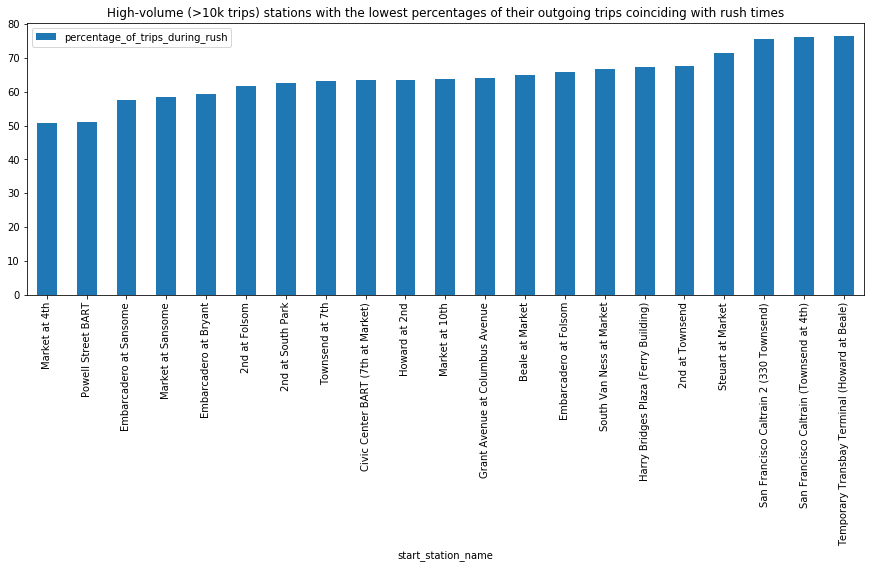

In [71]:
#Plotting bar chart of 
E_df.plot(x ='start_station_name', y='percentage_of_trips_during_rush', kind = 'bar', figsize = (15,5), title = 'High-volume (>10k trips) stations with the lowest percentages of their outgoing trips coinciding with rush times')

_______________________________

### Research Question F: Leveraging all learning from Research Question C, D, E to determine a promotional strategy.

Based on the above analysis, the below offers seem promising:

1. System-wide Day Pass sale during Federal Holidays (+/- 1 day). 
   * Rationale: Whereas Federal Holidays (+/- 1 day) comprise less than 10% of days in a year, 38% of the lowest-ridership days for Subscribers occur during Federal Holidays (+/- 1 day). The demand increase would have a lower-than usual likelihood of disenfranchising Subscribers, which should be avoided. Also, system-wide sale is easier to manage and less likely to create local bike shortages.
   * Reference: Research Question C - 3rd pie chart<br><br>
   
2. System-wide Sunday Day Pass sale
    * Rationale: 52% of the lowest-ridership days for Subscribers occur during Sundays. The demand increase would have a lower-than usual likelihood of disenfranchising Subscribers.
    * Reference: Research Question C - 2nd pie chart    <br><br>

3. December Subscription Sale
    * Rationale: As there are fewer trips in Winter (December especially), a sustained demand increase would have a lower-than usual likelihood of disenfranchising Subscribers. This also would provide the company lead time to procure more supply (bikes, docks, etc) in advance of peak season in upcoming Spring/Summer/Fall months.
    * Reference: Research Question D, Research Question C - 1st pie chart <br><br>
    
4. One-Way Trip Sale for 'Market at 4th' and 'Powell Street BART' via QR code at station (for mobile app).
    * Rationale: When examining high-usage stations, 'Market at 4th' and 'Powell Street BART' appear as outliers for lowest percentage of outgoing trips coinciding with rush times. While they may be location-specific reasons for this (undefined in data), this may be an opportunity to increase ridership at a high-usage station with minimal disenfranchising of Subscribers.
    * Reference: Research Question E